In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import csv
import numpy as np

# Read runtimes from logfiles

In [3]:
def read_logfile(logfile):
    runtimes_dict = []
    header = None
    with open(logfile, 'r') as f:
        for line in csv.reader(f):
            if header is None:
                header = line
            else:
                runtime_dict = {}
                for (header_elem, line_elem) in zip(header, line):
                    if header_elem != 'scenario':
                        if line_elem == '':
                            runtime_dict[header_elem] = None
                        else:
                            runtime_dict[header_elem] = float(line_elem)
                    else:
                        runtime_dict[header_elem] = line_elem
                runtimes_dict.append(runtime_dict)
    return runtimes_dict

import json
import os
import re
def read_real_system_runtimes(parent_dir):
    runtimes_dict = []
    tot_count = 0.
    count_failing = 0.
    for sub_dir in os.listdir(parent_dir):
        m = re.match(r'(.*),model=(.*)(,.*)?', sub_dir)
        if m is not None:
            scenario = m.group(1)
            model = m.group(2)
            runtime_dict = {"scenario": scenario, "model": model}
            
            full_logpath = os.path.join(parent_dir, sub_dir, "per_instance_stats.json")
            try:
                with open(full_logpath, 'r') as f:
                    all_instance_stats = json.load(f)
                    runtimes = []
                    idealized_runtimes = []
                    denoised_runtimes = []
                    for per_instance_stats in all_instance_stats:
                        stats = per_instance_stats["stats"]
                        runtime = None
                        num_output_tokens_in_per_instance_metrics = None
                        for stat in stats:
                            if stat["name"]["name"] == "inference_runtime":
                                if stat["count"] > 0:
                                    runtimes.append(stat["mean"])
                            elif stat["name"]["name"] == "inference_idealized_runtime":
                                if stat["count"] > 0:
                                    idealized_runtimes.append(stat["mean"])
                            elif stat["name"]["name"] == "inference_denoised_runtime":
                                if stat["count"] > 0:
                                    denoised_runtimes.append(stat["mean"])
                    runtime_dict["inference_runtime"] = np.mean(runtimes)
                    runtime_dict["inference_idealized_runtime"] = np.mean(idealized_runtimes)
                    runtime_dict["inference_denoised_runtime"] = np.mean(denoised_runtimes)
                    
                    tot_count += 1
                    if np.mean(denoised_runtimes) > 1.05 * np.mean(runtimes):
                        count_failing += 1
                        print(scenario, model, np.mean(runtimes), np.mean(denoised_runtimes))
                    
                    runtimes_dict.append(runtime_dict)
            except Exception as e:
                print(full_logpath, e)
    print(f"Fraction failing: {count_failing / tot_count:.3f}")
        
    return runtimes_dict

In [4]:
runtimes_dict = read_real_system_runtimes("../benchmark_output/runs/latest")

/Users/deepak/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/deepak/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


raft:subset=tai_safety_research anthropic_stanford-online-all-v4-s3,data_augmentation=canonical 1.21486500898997 1.2849479492187499
math:subject=geometry,level=1,use_official_examples=False,use_chain_of_thought=True anthropic_stanford-online-all-v4-s3 4.742853098112058 5.421839691790618
math:subject=prealgebra,level=1,use_official_examples=False,use_chain_of_thought=True anthropic_stanford-online-all-v4-s3 4.742853098112058 5.421839691790618
babi_qa:task=all openai_ada 0.1472866530418396 0.1671800244140625
synthetic_efficiency:tokenizer=huggingface_gpt2,num_prompt_tokens=1536,num_output_tokens=8,random=None openai_davinci 0.4674014329910278 0.5229999999999999
babi_qa:task=3 openai_ada 0.16175467014312744 0.199676205078125
truthful_qa:task=mc_single openai_ada,data_augmentation=canonical 0.13781137780967048 0.1652614569591029
synthetic_efficiency:tokenizer=huggingface_gpt2,num_prompt_tokens=1536,num_output_tokens=4,random=None openai_davinci 0.3571742057800293 0.399
synthetic_efficiency

# Plot runtimes versus idealized runtimes for various models

In [5]:
def plot_runtime_versus_estimated_runtime(runtimes_dict, label,
                                          metric_name,
                                          filter_fn=None,
                                          output_filename=None):
    print(label)
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    for runtime_dict in runtimes_dict:
        if filter_fn is None or filter_fn(runtime_dict):
            ax.scatter(runtime_dict["inference_runtime"],
                       runtime_dict[metric_name],
                       marker='o', color='black')
    ax.plot([0.1, 100], [0.1, 100], color='black', linestyle=':')

    # ax.set_xlim(0.1, 100)
    # ax.set_ylim(0.1, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Runtime (seconds)")
    if metric_name == "inference_denoised_runtime":
        ax.set_ylabel("Denoised runtime\n(seconds)")
    elif metric_name == "inference_idealized_runtime":
        ax.set_ylabel("Idealized runtime\n(seconds)")
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    plt.show()

All (denoised)


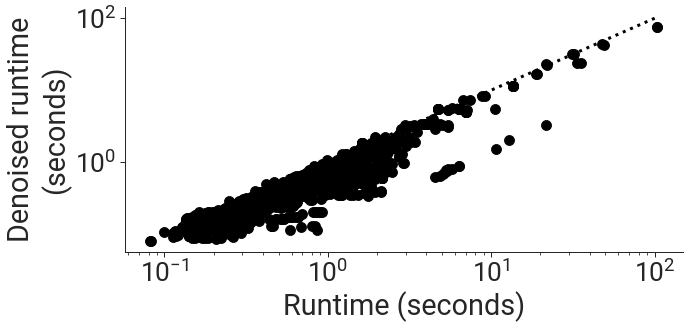

All (idealized)


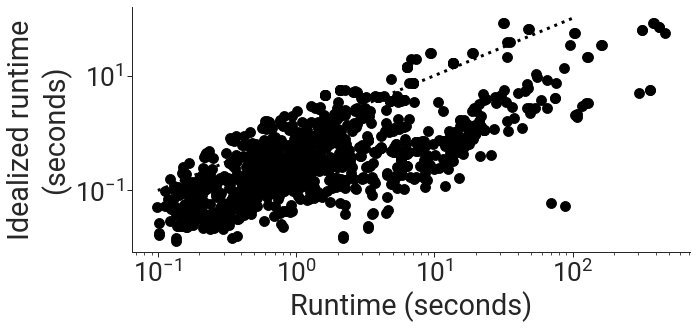

In [6]:
plot_runtime_versus_estimated_runtime(runtimes_dict, "All (denoised)",
                                      metric_name="inference_denoised_runtime",
                                      output_filename="../figures/runtime_vs_denoised_runtime/all_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "All (idealized)",
                                      metric_name="inference_idealized_runtime",
                                      output_filename="../figures/runtime_vs_idealized_runtime/all_v2.pdf")

AI21/j1-jumbo


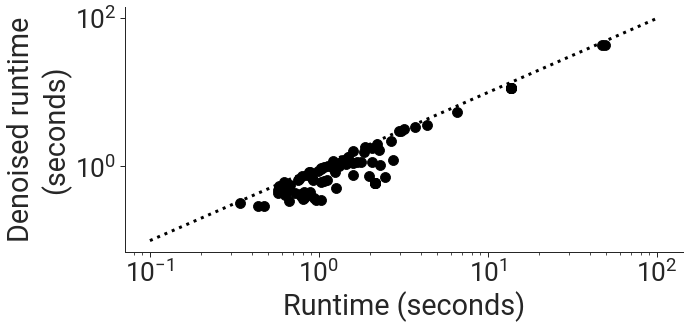

AI21/j1-grande


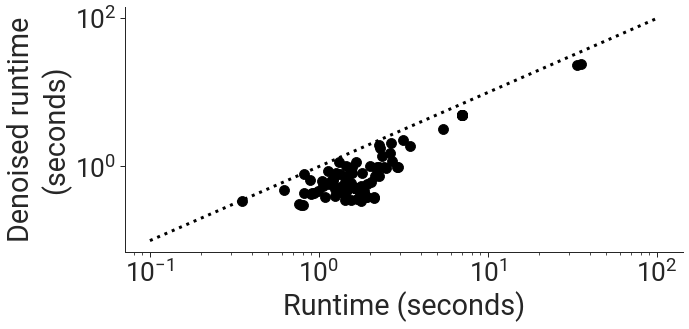

AI21/j1-large


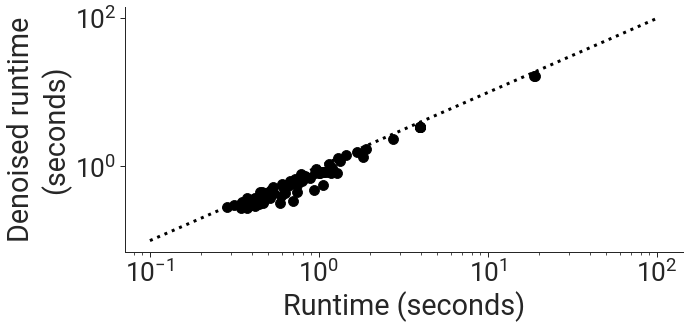

Anthropic


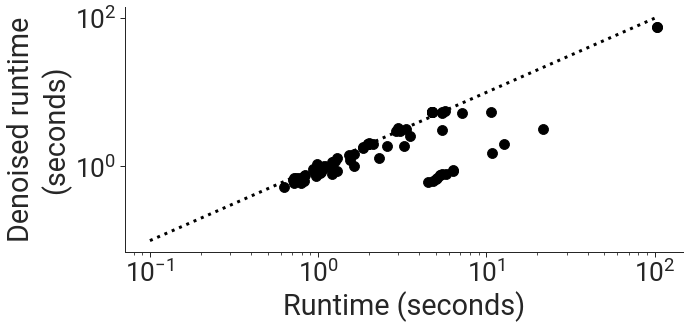

MT-Turing-NLG


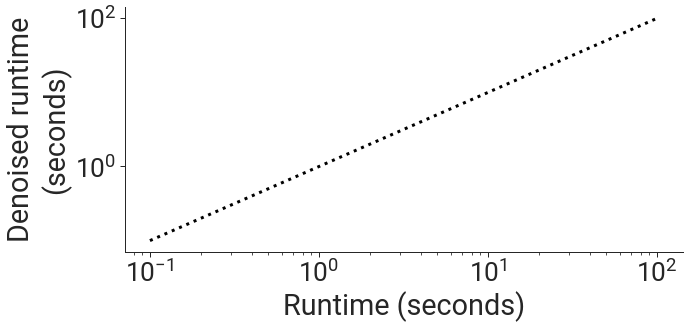

OpenAI/davinci


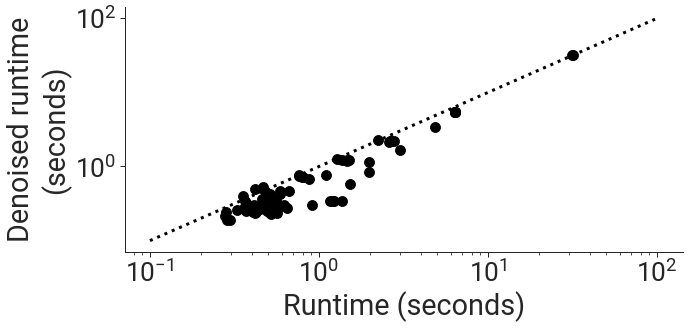

OpenAI/text-davinci-002


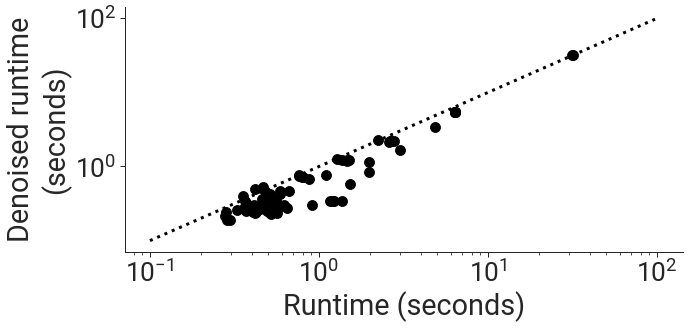

AI21/j1-jumbo


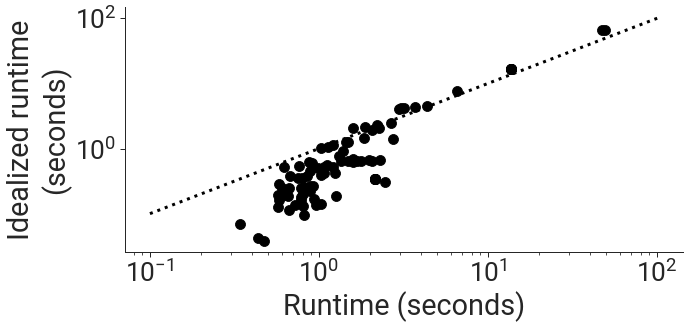

AI21/j1-grande


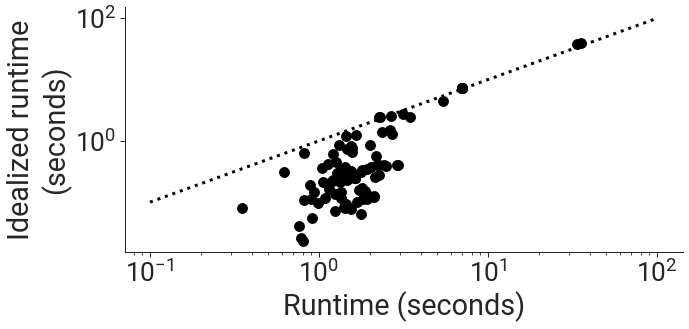

AI21/j1-large


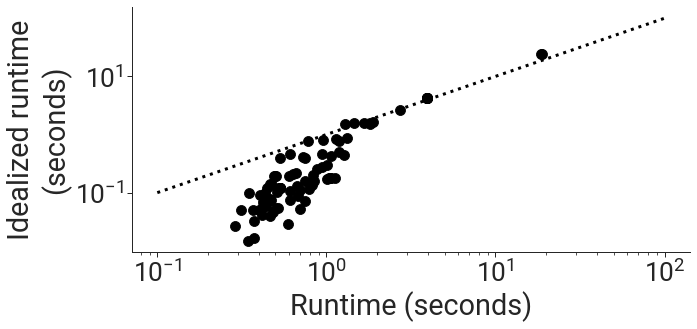

Anthropic


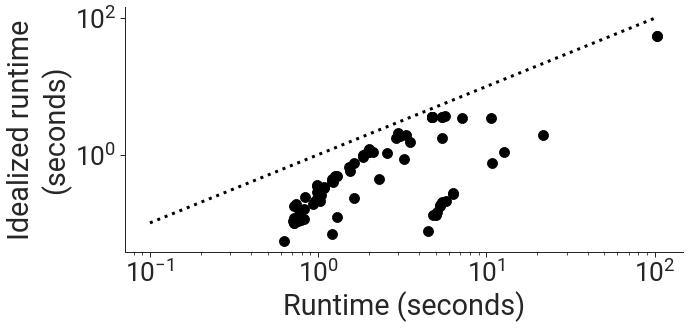

MT-Turing-NLG


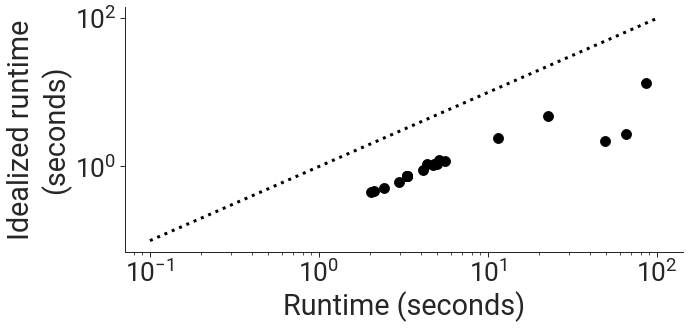

OpenAI/davinci


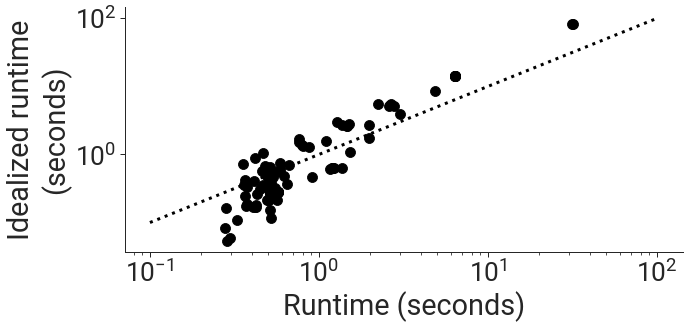

OpenAI/text-davinci-002


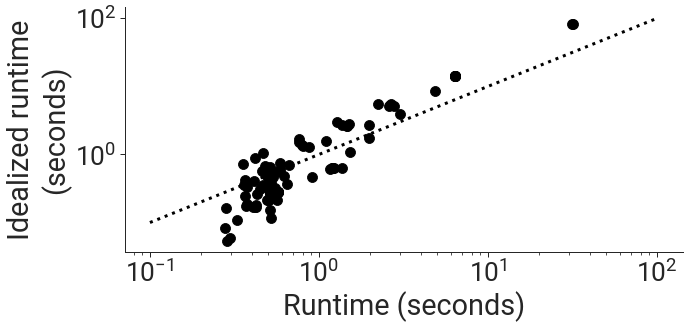

In [7]:
def filter_fn(runtime_dict, model):
    return model == runtime_dict["model"]

plot_runtime_versus_estimated_runtime(runtimes_dict, "AI21/j1-jumbo", "inference_denoised_runtime",
                                      lambda x: filter_fn(x, "ai21_j1-jumbo"),
                                      output_filename="../figures/runtime_vs_denoised_runtime/ai21_j1_jumbo_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "AI21/j1-grande", "inference_denoised_runtime",
                                      lambda x: filter_fn(x, "ai21_j1-grande"),
                                      output_filename="../figures/runtime_vs_denoised_runtime/ai21_j1_grande_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "AI21/j1-large", "inference_denoised_runtime",
                                      lambda x: filter_fn(x, "ai21_j1-large"),
                                      output_filename="../figures/runtime_vs_denoised_runtime/ai21_j1_large_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "Anthropic", "inference_denoised_runtime",
                                      lambda x: filter_fn(x, "anthropic_stanford-online-all-v4-s3"),
                                      output_filename="../figures/runtime_vs_denoised_runtime/anthropic_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "MT-Turing-NLG", "inference_denoised_runtime",
                                      lambda x: filter_fn(x, "microsoft_TNLGv2_530B"),
                                      output_filename="../figures/runtime_vs_denoised_runtime/mt_nlg_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "OpenAI/davinci", "inference_denoised_runtime",
                                      lambda x: filter_fn(x, "openai_davinci"),
                                      output_filename="../figures/runtime_vs_denoised_runtime/openai_davinci_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "OpenAI/text-davinci-002", "inference_denoised_runtime",
                                      lambda x: filter_fn(x, "openai_davinci"),
                                      output_filename="../figures/runtime_vs_denoised_runtime/openai_text-davinci-002_v2.pdf")

plot_runtime_versus_estimated_runtime(runtimes_dict, "AI21/j1-jumbo", "inference_idealized_runtime",
                                      lambda x: filter_fn(x, "ai21_j1-jumbo"),
                                      output_filename="../figures/runtime_vs_idealized_runtime/ai21_j1_jumbo_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "AI21/j1-grande", "inference_idealized_runtime",
                                      lambda x: filter_fn(x, "ai21_j1-grande"),
                                      output_filename="../figures/runtime_vs_idealized_runtime/ai21_j1_grande_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "AI21/j1-large", "inference_idealized_runtime",
                                      lambda x: filter_fn(x, "ai21_j1-large"),
                                      output_filename="../figures/runtime_vs_idealized_runtime/ai21_j1_large_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "Anthropic", "inference_idealized_runtime",
                                      lambda x: filter_fn(x, "anthropic_stanford-online-all-v4-s3"),
                                      output_filename="../figures/runtime_vs_idealized_runtime/anthropic_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "MT-Turing-NLG", "inference_idealized_runtime",
                                      lambda x: filter_fn(x, "microsoft_TNLGv2_530B"),
                                      output_filename="../figures/runtime_vs_idealized_runtime/mt_nlg_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "OpenAI/davinci", "inference_idealized_runtime",
                                      lambda x: filter_fn(x, "openai_davinci"),
                                      output_filename="../figures/runtime_vs_idealized_runtime/openai_davinci_v2.pdf")
plot_runtime_versus_estimated_runtime(runtimes_dict, "OpenAI/text-davinci-002", "inference_idealized_runtime",
                                      lambda x: filter_fn(x, "openai_davinci"),
                                      output_filename="../figures/runtime_vs_idealized_runtime/openai_text-davinci-002_v2.pdf")